In [2]:
%matplotlib inline

import numpy as np
import math as m
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import cmocean 
from matplotlib.ticker import EngFormatter, StrMethodFormatter

In [3]:
#Defintion of subsequently used functions
def sin(theta):
    return np.sin(np.deg2rad(theta))
def cos(theta):
    return np.cos(np.deg2rad(theta))

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    #https://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector
    
    axis = axis/np.linalg.norm(axis)
    a = np.cos(theta/2.0)
    b, c, d = -axis*np.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

#Function to transform from cartesian to spherical coordinates
def cart2sph(array):
    XsqPlusYsq = array[0]**2 + array[1]**2
    r = m.sqrt(XsqPlusYsq + array[2]**2)               # r
    elev = m.pi/2-m.atan2(array[2],m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(array[1],array[0])                           # phi
    return r, elev, az

In [4]:
#Dictionary with the constructed backbone geometry.
c = {}  
c['Co0'] = np.array([0.,0.,0.])
c['Ca0'] = np.array([0.,0.,1.53])
c['O0'] = np.array([0.,1.24*sin(121),1.24*cos(121)])
c['N1'] = np.array([0.,1.32*sin(-114),1.32*cos(-114)])
c['H1'] = c['N1']+np.array([0.,1.04*sin(-114+57),1.04*cos(-114+57)])
c['Ca1'] = c['N1']+np.array([0.,1.47*sin(-114-57),1.47*cos(-114-57)])

Co_O = (c['O0']-c['Co0'])/np.linalg.norm(c['O0']-c['Co0'])
Co_N = (c['N1']-c['Co0'])/np.linalg.norm(c['N1']-c['Co0'])
rot = np.cross(Co_N,Co_O)
#Definition of the carbonyl CSA_yy and CSA_xx components as unit vectors.
s_xx = np.dot(rotation_matrix(rot,np.deg2rad(37)),Co_N)
c['Co_xx'] = s_xx/np.linalg.norm(s_xx)
s_yy = np.dot(rotation_matrix(rot,np.deg2rad(37+90)),Co_N)
c['Co_yy'] = s_yy/np.linalg.norm(s_yy)   

NH = (c['H1']-c['N1'])/np.linalg.norm(c['H1']-c['N1'])
N_Co = (c['Co0']-c['N1'])/np.linalg.norm(c['Co0']-c['N1'])
rot1 = np.cross(NH,N_Co)
#Definition of the nitrogen CSA_xx component
n_xx = c['N1']+np.dot(rotation_matrix(rot1,np.deg2rad(20)),NH)/np.linalg.norm(np.dot(rotation_matrix(rot1,np.deg2rad(20)),NH))
c['N_xx'] = n_xx  

In [5]:
#physical parameters  
h_bar = 1.05457180013e-34 # m^2 kg s⁻1 / planck energy divided by 2pi
mu_naught = 4.0*m.pi*1.0e-7 # kg m s^-2 A^-2 / vacuum permiability
gamma_c = 67.262e6 # rad s A kg^-1 / gyromagnetic ratio in rad s^−1 T^−1
gamma_h = 267.513e6 # rad s A kg^-1 / gyromagnetic ratio in rad s^−1 T^−1
gamma_n = -27.116e6 # rad s A kg^-1 / gyromagnetic ratio in rad s^−1 T^−1

angstrom_correction = 1.0e10**3

s_xx = 249.4e-6
s_yy = 191.1e-6
s_zz = 87.9e-6
n_xx = 170e-6

In [6]:
#definition of the spectral density funciton: it reads two vectors and transforms the latter in spherical coordinates. 
#It also read the order parameter and the omega
def spectral_density(vec1,vec2,omega,S2):
    vec1_s = cart2sph(vec1)  
    vec2_s = cart2sph(vec2)
    A1 = (1.5*m.cos(vec1_s[1])**2-0.5)*(1.5*m.cos(vec2_s[1])**2-0.5)
    
    #note that this expression is equivalent to A1 in the manuscript since 2sin(a)cos(a)= sin(2a)
    A2 = 3*m.sin(vec1_s[1])*m.cos(vec1_s[1])*m.sin(vec2_s[1])*m.cos(vec2_s[1])*m.cos(vec1_s[2]-vec2_s[2])
    
    A3 = 3/4*m.sin(vec1_s[1])**2*m.sin(vec2_s[1])**2*m.cos(2*vec1_s[2]-2*vec2_s[2])
    
    J = 0.4*(S2*((A1*t1)/(1+(omega*t1)**2)+(A2*t2)/(1+(omega*t2)**2)+(A3*t3)/(1+(omega*t3)**2)) +
         (1-S2)*(1.5*np.dot(vec1/np.linalg.norm(vec1),vec2/np.linalg.norm(vec2))**2-0.5)*t/(1+(omega*t)**2))
    return J


#Definition of the transversal DP/CSA CCR N_HN  
def CCR_NH_Nxx_t(DP,CSA,B0):
    
    prefactor = 1/24/m.pi*mu_naught*h_bar*gamma_n*gamma_h*gamma_n*B_0*angstrom_correction/((np.linalg.norm(DP))**3)
    
    J_0 = spectral_density(DP,CSA,0,S2)
    J_omega = spectral_density(DP,CSA,B_0*gamma_n,S2)

    return prefactor*n_xx*(4*J_0 + 3*J_omega)


#Definition of the longitudinal DP/CSA CCR N_HN  
def CCR_NH_Nxx_l(DP,CSA,B0):
    prefactor = 1/24/m.pi*mu_naught*h_bar*gamma_n*gamma_h*gamma_n*B_0*angstrom_correction/((np.linalg.norm(DP))**3)
    
    J_omega = spectral_density(DP,CSA,B_0*gamma_n,S2)

    return prefactor*n_xx*(6*J_omega)

#Definition of the transversal DP/CSA CCR Co_CaCo
def CCR_CoCa_Co_t(DP,CSA1,CSA2,B0):
    prefactor = 1/24/m.pi*mu_naught*h_bar*gamma_c*gamma_c*gamma_c*B_0*angstrom_correction/((np.linalg.norm(DP))**3)
    
    J1_0 = spectral_density(DP,CSA1,0,S2)
    J1_omega = spectral_density(DP,CSA1,B_0*gamma_c,S2)
    
    J2_0 = spectral_density(DP,CSA2,0,S2)
    J2_omega = spectral_density(DP,CSA2,B_0*gamma_c,S2)
    
    return prefactor*((s_xx-s_zz)*(4*J1_0+3*J1_omega)+(s_yy-s_zz)*(4*J2_0+3*J2_omega))

#Definition of the longitudinal DP/CSA CCR Co_CaCo
def CCR_CoCa_Co_l(DP,CSA1,CSA2,B0):
    prefactor = 1/24/m.pi*mu_naught*h_bar*gamma_c*gamma_c*gamma_c*B_0*angstrom_correction/((np.linalg.norm(DP))**3)
    
    J1_omega = spectral_density(DP,CSA1,B_0*gamma_c,S2)
    
    J2_omega = spectral_density(DP,CSA2,B_0*gamma_c,S2)
    
    return prefactor*((s_xx-s_zz)*6*J1_omega+(s_yy-s_zz)*6*J2_omega)

In [7]:
#################################CCR RATES SIMULATION AND PLOT##################################################
#The following piece of code can be iterated changing the input parameters according to Figure 4.

NameError: name 'cmocean' is not defined

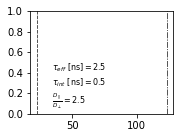

In [8]:
#Input parameters, that the user can change. 
D_ratio = 2.5    #D_par/D_per
tau = 2.5* 1e-9    # tau_eff =  (4D_par + 2D_par)**-1
t_int = 0.5* 1e-9  # tau_3**-1 = t_int**-1 + t_eff**-1
B_0 = 800e6*2*m.pi/gamma_h #multiply with gamma_c to get omega_c

#Parameters (function of the inputs) needed to compute the CCR rates defined above.
D = 1/(tau*6)
D_par = 3*D/(2*(D_ratio**-1)+1)
D_per = (D_ratio**-1)*D_par

t1 = (6*D_per)**-1
t2 = (5*D_per+D_par)**-1
t3 = (2*D_per+4*D_par)**-1
t = 1/(t_int**-1+4*D_per+2*D_par)

#Figure layout
cm = 1/2.54  #centimeters to inches
fig = plt.figure(figsize=(6.5*cm, 5*cm))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
textstr = '\n'.join((r'$\tau_{eff}\ $[ns]$ =%.1f$' % (tau*1e9, ), r'$\tau_{int}\ $[ns]$ =%.1f$' % (t_int*1e9, ), 
    r'$\frac{D_{\parallel}}{D_{\perp}} =%.1f$' % (D_ratio, )))

ax.text(0.15,0.1,  textstr, transform=ax.transAxes, fontsize=8)

#Plot the orientation of the N_HN and Ca_Ca vectors.
plt.axvline(x=22.2,label=r'$\parallel \,{C^{\alpha}C^{\alpha}}$',linestyle='dashed', color= '#555555',  linewidth=.9)
plt.axvline(x=123,label=r'$\parallel \, {NH^N}$',color='#555555', linestyle = 'dashdot', linewidth=0.9)
plt.axvline(x=22.2,color='#555555', linestyle = 'dashed', linewidth=0.9)
plt.axvline(x=123,color='#555555', linestyle = 'dashdot', linewidth=0.9)    

###########SIMULATION########

#Initialization of the Q ratio list.
lines = []
#The order parameter S2 is varied from 0 to 1.
for S2 in  [x*0.1 for x in range(0,11,1)]:  
    
    #Initialization of the rate's lists.
    l_CCR_NH_Nxx_t = []
    l_CCR_NH_Nxx_l = []
    l_CCR_CoCa_Co_t = []    
    l_CCR_CoCa_Co_l = []
    
    #The diffusion tensor is rotated about rot (i.e. the axis perpendicular to the peptide plane) by 1 degree, 
    #ranging from 0 to 180. 
    step=1
    for theta in range(0,181,step): 
        cr = deepcopy(c)
        theta = np.deg2rad(theta)
        rotate = rotation_matrix(rot,theta)
        
        #Each and every time the above defined vectors are rotated.
        for key in cr:
            cr[key] = np.dot(rotate,c[key])
            
        NH = (cr['H1']-cr['N1'])
        Nxx = (cr['N_xx']-cr['N1'])
        CoCa = (cr['Ca0']-cr['Co0'])
        Coxx = (cr['Co_xx']-cr['Co0'])
        Coyy = (cr['Co_yy']-cr['Co0'])
        NCo = (cr['Co0']-cr['N1'])
        NCa = (cr['Ca1']-cr['N1'])
        
        #The rates are determined using the previously defined functions, and are stored in the rate's lists.
        l_CCR_NH_Nxx_t.append(CCR_NH_Nxx_t(NH,Nxx,B_0))
        l_CCR_NH_Nxx_l.append(CCR_NH_Nxx_l(NH,Nxx,B_0))
        l_CCR_CoCa_Co_t.append(CCR_CoCa_Co_t(CoCa,Coxx,Coyy,B_0))       
        l_CCR_CoCa_Co_l.append(CCR_CoCa_Co_l(CoCa,Coxx,Coyy,B_0))
   
    #The Q ratio is determined as shown in eq. 16, and stored in its list.
    exp1_1=np.array(l_CCR_CoCa_Co_t)-1/2*(np.array(l_CCR_CoCa_Co_l))
    exp2_1=np.array(l_CCR_NH_Nxx_t)-1/2*np.array(l_CCR_NH_Nxx_l)
    lines.append(exp1_1/exp2_1)
    
    
    
    #####################Plot#########################
    
    
    #Assignment of a different color to each S2 value
    evenly_spaced_interval = np.linspace(0, 0.7, len(lines))
    colors = [cmocean.cm.ice(x) for x in evenly_spaced_interval]

    for i, color in enumerate(colors):
        
        ax.plot(lines[i], color = color, linewidth=0.5)

#Figure layout
ax.set_ylim(0.098, 0.52)
ax.set_xlim(0,180)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))
ax.set_xticks([0,30, 60, 90, 120, 150, 180])
ax.tick_params(labelsize=8)
ax.legend(fontsize=8)
ax.text(0.94, 0.94, r'$(a)$', transform=ax.transAxes,fontsize=10, fontweight='bold', va='center')
#plt.savefig('figure_4.svg')

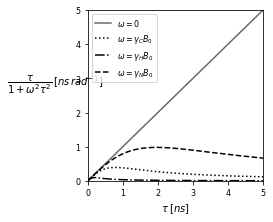

In [9]:
#####################################FIGURE 2##########################################################
#The obtained figure is tailored with Inkscape.

#Initialization of the lists.
c=[]
h=[]
n=[]
#Simulation of the reduced spectral density function as a function of tau (ranging from o to 5 ns). 
#The obtained values are then stored the above defined lists. 
taus = [x*1e-12 for x in range(0, 5001)]
for tau in taus:
    j_c=(tau/(1+(gamma_c*B_0*tau)**2)) *1e9
    j_h=(tau/(1+(gamma_h*B_0*tau)**2)) *1e9
    j_n = (tau/(1+(gamma_n*B_0*tau)**2)) *1e9
    c.append(j_c)
    h.append(j_h)
    n.append(j_n)
    
#The list are converted into arrays.
j_c = np.array(c)
j_h = np.array(h)
j_n = np.array(n)

#Figure layout

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(8*cm, 8*cm))

####################Plot###################################

#Tau varied from 0 to 5 ns (x vaxis)
t = [x*1e-12 *1e9 for x in range(0,5001)]

#Plot of the different obtain functions (y axis )
ax.plot(t, t, color='dimgrey', label=(r'$\omega = 0$'))
ax.plot(t, j_c, color='black', linestyle='dotted', label=(r'$\omega = \gamma_{C}B_0$'))
ax.plot(t, j_h, color= 'black', linestyle='dashdot', label=(r'$\omega = \gamma_{H}B_0$'))
ax.plot(t, j_n, color='black', linestyle= 'dashed', label=(r'$\omega = \gamma_{N}B_0$'))

#Figure layout.
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.tick_params(labelsize=8)
ax.legend(fontsize=8)
ax.set_ylabel(r'$\dfrac{\tau}{1+\omega^2\tau^2}\,[ns\,rad^{-1}]$', fontsize=10, rotation=360
              , labelpad=20)
ax.set_xlabel(r'$\tau \: [ns]$', fontsize=10)
#plt.savefig('figure_1.svg')